## Exploratory Data Analysis

                     expver  csf  lsf        bld      lgws        ewss  \
valid_time                                                               
2020-01-01 00:00:00       1  0.0  0.0   673.4429  0.074219   -3.089844   
2020-01-01 06:00:00       1  0.0  0.0  2136.6719 -0.585938 -293.017820   
2020-01-01 12:00:00       1  0.0  0.0  1061.0012  0.830566  -12.405273   
2020-01-01 18:00:00       1  0.0  0.0  1393.3027  0.289551   -9.126709   
2020-01-02 00:00:00       1  0.0  0.0  1084.0913 -0.237549  -24.880127   

                          gwd     avg_esrwe       msr         d2m  ...  \
valid_time                                                         ...   
2020-01-01 00:00:00 -2.352273 -3.910827e-10  0.000045  264.102959  ...   
2020-01-01 06:00:00  6.275649 -7.639756e-10  0.001441  268.436476  ...   
2020-01-01 12:00:00  4.615299 -4.237108e-10  0.003000  268.563372  ...   
2020-01-01 18:00:00  0.881665 -1.491571e-10  0.007811  266.972386  ...   
2020-01-02 00:00:00 -3.379859 -2.9615

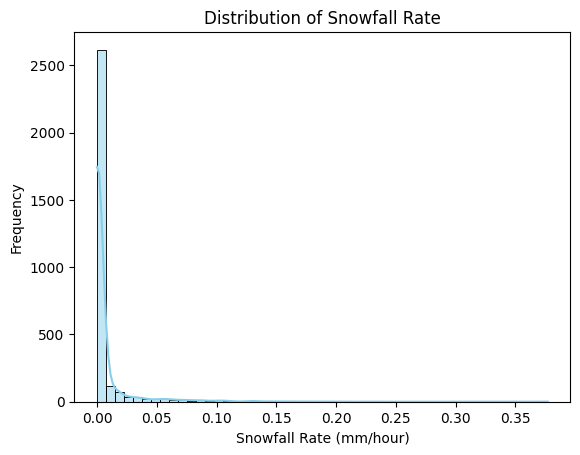

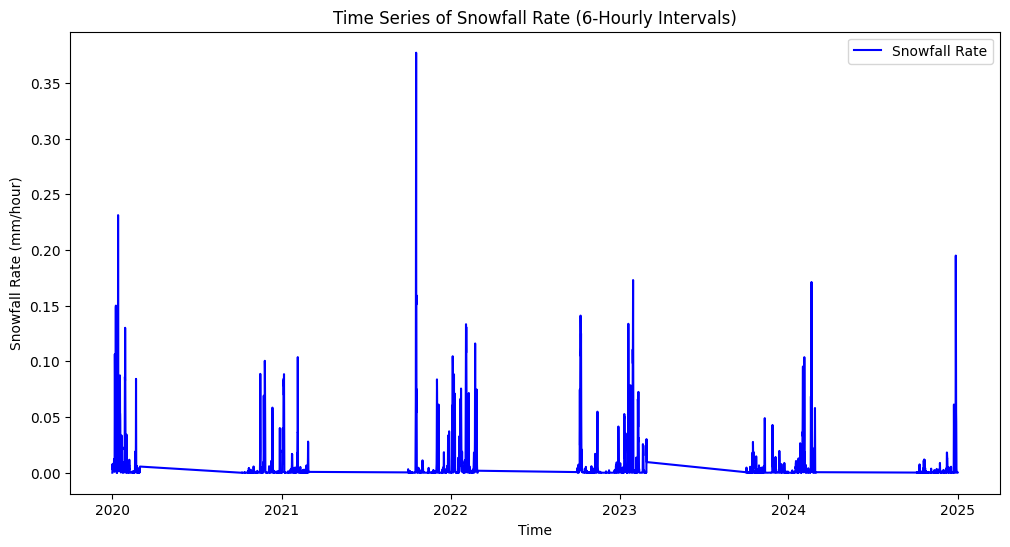

In [50]:
import numpy as np
import statsmodels
import xarray as xr
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\pgd24-013121114\Downloads\findata\sample.csv")
df.head()

# Convert time to datetime
df['valid_time'] = pd.to_datetime(df['valid_time'])

# Extract temporal features
df['year'] = df['valid_time'].dt.year
df['month'] = df['valid_time'].dt.month
df['day'] = df['valid_time'].dt.day
df['hour'] = df['valid_time'].dt.hour
df['dayofyear'] = df['valid_time'].dt.dayofyear
df['weekofyear'] = df['valid_time'].dt.isocalendar().week


df.set_index('valid_time', inplace=True)
print(df.head())

df.info()

# Summary statistics
df.describe()
print(df.index.max())
sns.histplot(df['msr'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Snowfall Rate')
plt.xlabel('Snowfall Rate (mm/hour)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['msr'], color='blue', label='Snowfall Rate')
plt.title('Time Series of Snowfall Rate (6-Hourly Intervals)')
plt.xlabel('Time')
plt.ylabel('Snowfall Rate (mm/hour)')
plt.legend()
plt.show()


# Compute wind speed and direction from u and v components

def wind_speed(u, v):
    return np.sqrt(u**2 + v**2)

def wind_direction(u, v):
    return np.degrees(np.arctan2(v, u)) % 360

# Create wind speed and direction features
df['wind_speed_100m'] = wind_speed(df['u100'], df['v100'])
df['wind_speed_10m'] = wind_speed(df['u10n'], df['v10n'])
df['wind_dir_100m'] = wind_direction(df['u100'], df['v100'])
df['wind_dir_10m'] = wind_direction(df['u10n'], df['v10n'])

# plt.figure(figsize=(40,40))
df1= df.copy()
df1 = df1.drop(columns=['u100','v100','u10n','v10n','dayofyear','weekofyear','year', 'day', 'hour'])



## Plot seasonal data for specified years from Oct to Feb.

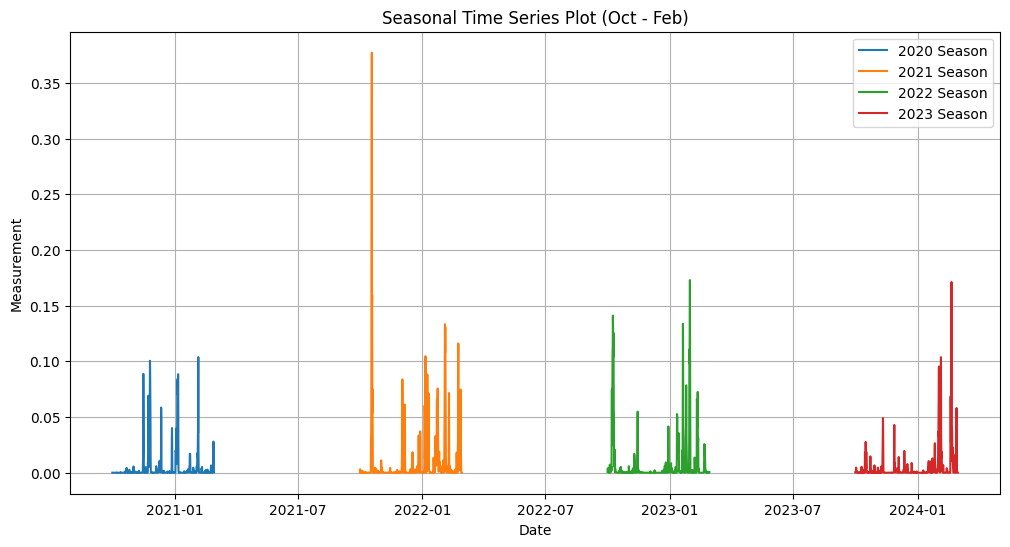

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
 
def plot_seasonal_data(X, y, years):
    """Plot seasonal data for specified years from Oct to Feb."""
    plt.figure(figsize=(12, 6))
    for year in years:
        # Define start and end dates for each season
        start_date = pd.Timestamp(f'{year}-10-01')
        # Handle leap years correctly
        try:
            end_date = pd.Timestamp(f'{year+1}-02-29')
        except ValueError:
            end_date = pd.Timestamp(f'{year+1}-02-28')
        # Filter data for the current season
        y_season = y.loc[start_date:end_date]
        # Plot the season
        if not y_season.empty:
            plt.plot(y_season.index, y_season, label=f'{year} Season')
 
    # Plot settings
    plt.title('Seasonal Time Series Plot (Oct - Feb)')
    plt.xlabel('Date')
    plt.ylabel('Measurement')
    plt.legend()
    plt.grid(True)
    plt.show()
 
# 🎯 Plot the seasonal data for selected years
plot_seasonal_data(df.index, df['msr'], [2020, 2021, 2022, 2023])

## STL decomposition(time series decomposition)

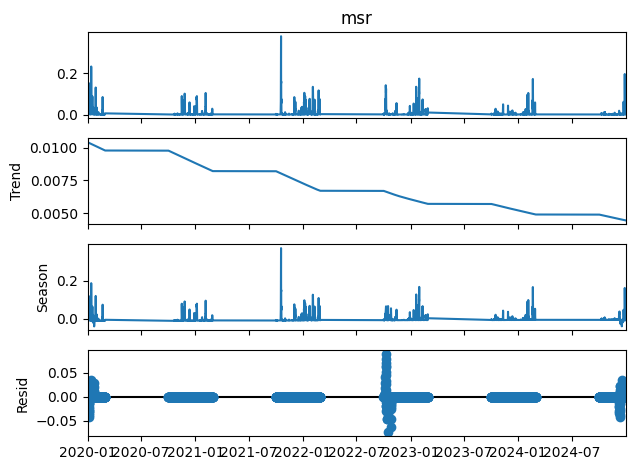

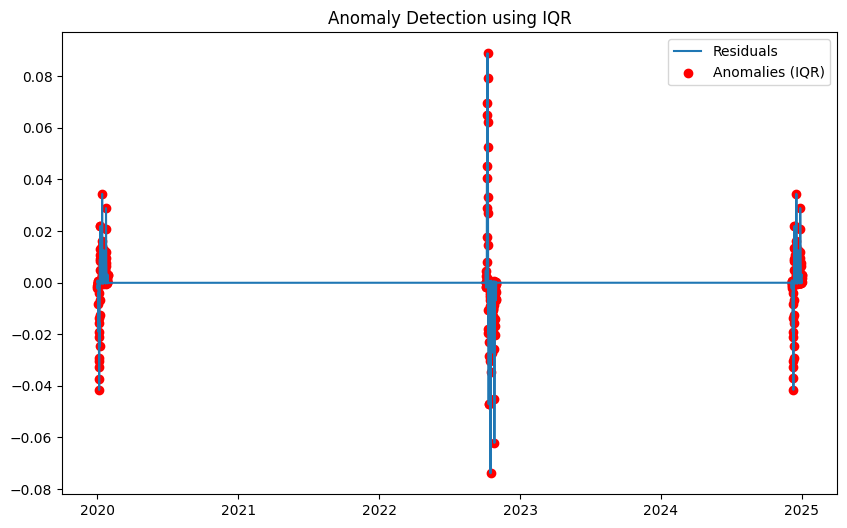

ADF Statistic: -10.946736142862889
p-value: 9.007580385969279e-20
The data is stationary. Proceed with ARIMA.


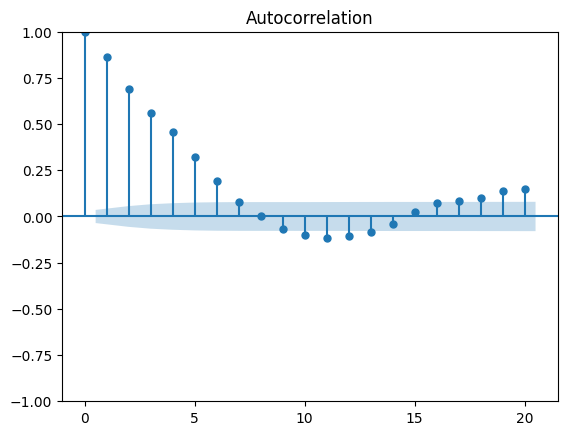

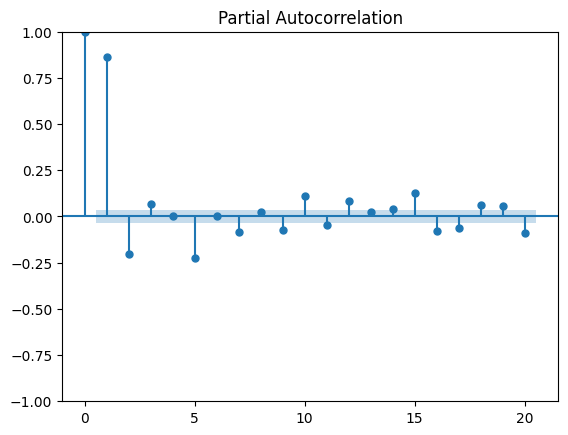

In [54]:

##STL decomposition(time series decomposition)
from statsmodels.tsa.seasonal import STL
import pandas as pd
import matplotlib.pyplot as plt

# Convert date and set as index
# df['date'] = pd.to_datetime(data['date'])  # Change 'date' column name if needed
# data.set_index('date', inplace=True)

# Set frequency explicitly
# df1 = df1.asfreq('6H')

# Drop NaNs and perform STL
df1['msr'].dropna(inplace=True)
stl = STL(df1['msr'], period=1460)  # Set period based on frequency
result = stl.fit()

# Plot the decomposition
result.plot()
plt.show()



##IQR test for anamoly detection

residuals = result.resid
# Extract residuals
# Calculate IQR
Q1, Q3 = np.percentile(residuals.dropna(), [25, 75])
IQR = Q3 - Q1

# Define bounds for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect anomalies
anomalies_iqr = residuals[(residuals < lower_bound) | (residuals > upper_bound)]

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.scatter(anomalies_iqr.index, anomalies_iqr, color='red', label='Anomalies (IQR)')
plt.title('Anomaly Detection using IQR')
plt.legend()
plt.show()



## adfuller test for stationarity check
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(residuals)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# p-value < 0.05 indicates stationarity
if result[1] > 0.05:
    print("The data is not stationary. Applying differencing...")
    residuals_diff = residuals.diff().dropna()
else:
    print("The data is stationary. Proceed with ARIMA.")




import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to choose p and q
plot_acf(residuals.dropna(), lags=20)
plot_pacf(residuals.dropna(), lags=20)
plt.show()



## PDQ model parameters justify


## AIC and BIC values

In [56]:

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Load your time series data
# data = pd.read_csv('snowfall_data.csv', parse_dates=['Date'], index_col='Date')

# Fit ARIMA model with parameters (p, d, q)
model_1 = ARIMA(df1['msr'], order=(2, 0, 1)).fit()
model_2 = ARIMA(df1['msr'], order=(2, 0, 0)).fit()

# Print AIC and BIC values
print(f"Model 1: AIC = {model_1.aic}, BIC = {model_1.bic}")
print(f"Model 2: AIC = {model_2.aic}, BIC = {model_2.bic}")




D:\Anaconda\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\envs\ml\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\envs\ml\Lib\site-package

Model 1: AIC = -18301.016723799155, BIC = -18270.93843572637
Model 2: AIC = -18302.243619711327, BIC = -18278.1809892531


## Best Model

In [58]:
# Automatically select the best model using auto_arima
from pmdarima import auto_arima

auto_model = auto_arima(df1['msr'], seasonal=False, trace=True, suppress_warnings=True)

print(f"Best Model: {auto_model.summary()}")


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\ml\Lib\site-packag

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-18288.157, Time=1.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14431.514, Time=0.16 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-18120.989, Time=0.44 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-16689.017, Time=0.28 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-18271.231, Time=0.40 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-18266.029, Time=0.88 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-18261.737, Time=2.00 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-18296.061, Time=0.42 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-18292.751, Time=0.46 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-18293.051, Time=0.83 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-18297.036, Time=0.95 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-18298.211, Time=0.27 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-18140.619, Time=1.25 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,5)(0,0,0)[0]             : AIC=-18296.617, Time=0.77 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-18004.076, Time=0.93 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-18224.675, Time=1.89 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-18294.526, Time=1.59 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-18331.908, Time=1.31 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-18213.682, Time=3.38 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-18321.984, Time=0.57 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-18332.063, Time=1.51 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-18327.747, Time=1.07 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-18330.696, Time=2.24 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=-18330.344, Time=1.63 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=-18332.090, Time=1.97 sec


D:\Anaconda\envs\ml\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=-18284.297, Time=3.73 sec

Best model:  ARIMA(1,0,5)(0,0,0)[0] intercept
Total fit time: 32.434 seconds
Best Model:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3028
Model:               SARIMAX(1, 0, 5)   Log Likelihood                9174.045
Date:                Thu, 27 Mar 2025   AIC                         -18332.090
Time:                        13:03:08   BIC                         -18283.965
Sample:                             0   HQIC                        -18314.788
                               - 3028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.001      3.138      0.0